In [20]:
import re
from numpy import array as array

import unittest 
import numpy as np
import numpy.linalg as la
from numpy import array, pi, cos, sin, sqrt, linspace
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%load_ext autoreload
%autoreload 2

%matplotlib notebook

from Fullerene_GeometryFunctions.py import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) 

NA = np.newaxis

## Conversion from Hatree/Borh^2 to N/M 
NM=(4.3597e-18)/((5.29177210903e-11)**2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

## Skriv dem ind i fullerene_functions
def read_geometry(file):
    
    f = open(file, "r")
        
    lines = f.readlines()
    
    N = None
    for i in range(len(lines)):
        if isinstance(int(re.search(r'\d+', file).group()),int):
            N = int(re.search(r'\d+', file).group())

        elif "NAtoms=" in lines[i]:
            N = re.search(r'\d+', lines[i]).group()

        else:
            print('What is the number of atoms N ?')

            
        if "Standard orientation:" in lines[i]:
            coord_lines = lines[i+5:i+5+N]
            coord = np.array([l.split()[-3:] for l in coord_lines],dtype=float)
            return coord
    return None



def get_Hessian(file,N):
    f = open(file, "r")
    txt = f.read()
    f.close()
    hess = re.split("Hessian after L703:", txt)[1] 
    hess = re.split("Leave Link  703", hess)[0]
    hess = hess.strip()
    column_index_line = re.compile("(\s*[0-9]+\s+[0-9]+\s+[0-9]+\s+[0-9]+\s+[0-9]+\s+)")
 
    Hessian = np.zeros([N,N,3,3])
    
    for line in hess.splitlines():
        if column_index_line.match(line):
            ## line is an column index line ##
            column_id = np.fromstring(re.sub("\s+", ",",  line.strip()), sep=",", dtype=int) - 1
        else:
            ## line is not an column index line ##
            line = re.sub("D", "E", line)
            data_line = np.fromstring(re.sub("\s+", ",",  line.strip()), sep=",")
                  
            if len(data_line) == 0:
                return Hessian
            
            row_id = int(data_line[0]) - 1
            
            data_line = data_line[1:]
            for i in range(len(data_line)):
                atom_row = row_id//3
                atom_col = column_id[i]//3

                Hessian[atom_row,atom_col, row_id%3, column_id[i]%3] = data_line[i]
                Hessian[atom_col,atom_row, row_id%3,column_id[i]%3] = data_line[i]
    return Hessian

## Import Data

In [22]:
from C60ih import *
print(points_opt.shape)
print(cubic_neighbours.shape)
print(pentagons.shape)
print(hexagons.shape)

(60, 3)
(60, 3)
(12, 5)
(20, 6)


In [23]:
geom = read_geometry("C60_Ih_m062x_freq_symIh.log")
hessian = get_Hessian("C60_Ih_m062x_freq_symIh.log",60)
print(geom.shape)
print(hessian.shape)

print(f'hessian sanity check hessian[0,1]-hessian[1,0]:\n {hessian[0,1]-hessian[1,0]}')

(60, 3)
(60, 60, 3, 3)
hessian sanity check hessian[0,1]-hessian[1,0]:
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


<IPython.core.display.Javascript object>


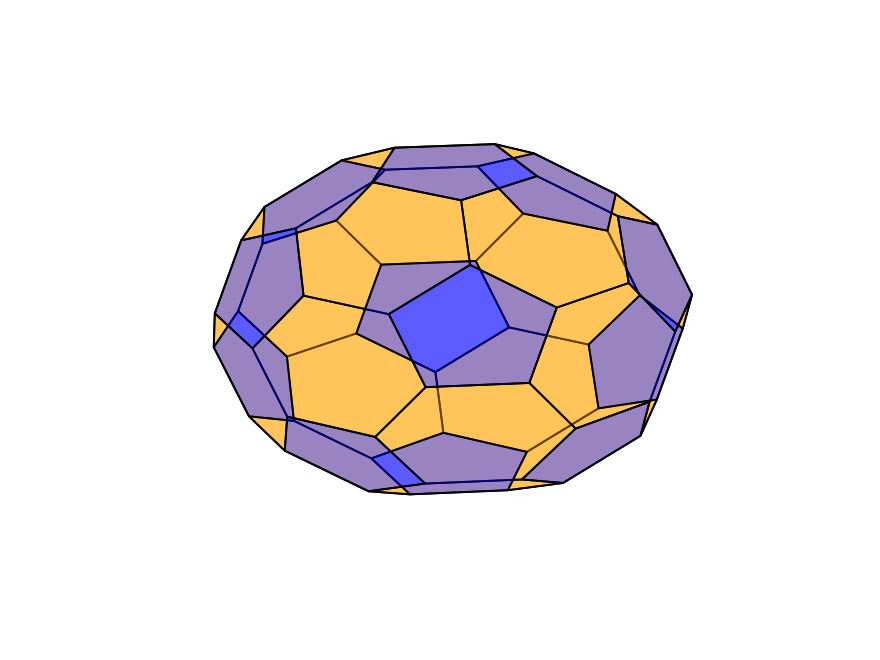

In [24]:
plotting_faces(geom,pentagons,hexagons,ap=0.4,ah=0.4)

## Seminario 

In [25]:
def force_const(H,d): 
    # H, the sub hessian
    # d, the direction of the force

    lam, U = np.linalg.eig(-H)
    
    kr = np.dot(lam,np.abs([np.dot(U[:,i],d) for i in range(3)]))
    return kr*NM

In [26]:
def bond_FC(geom,hess,neigh,face):

    FC_pp = np.empty(0)
    FC_ph = np.empty(0)
    FC_hh = np.empty(0)
    FC   = np.empty(0)

    
    for i in range(len(geom)):
        atom_faces = face[i] + np.roll(face[i],shift=1)
        for j in range(3):
            hs = hess[neigh[i,j],i]
            d = geom[neigh[i,j]] - geom[i]
            r = np.linalg.norm(d)
            dhat = d/r
            
            n = atom_faces[j]
            FC = np.append(FC,force_const(hs,dhat))
            if n == 10:
                FC_pp = np.append(FC_pp,force_const(hs,dhat))

            elif n == 11:
                FC_ph=np.append(FC_ph,force_const(hs,dhat))

            else:
                FC_hh=np.append(FC_hh,force_const(hs,dhat))

            
    return np.array(FC_pp),np.array(FC_ph),np.array(FC_hh), FC

In [27]:
def ang_FC(geom,hess,neigh,sortedFaces):
    FC_p = np.empty(0)
    FC_h = np.empty(0)
    FC   = np.empty(0)

    for i in range(len(geom)):
        neigh2 = np.empty(0)
        neigh2 = np.append(neigh[i],neigh[i])
        for j in range(3):


            A, B, C = i, neigh2[j], neigh2[j+1]


            hess_AB = hess[A,B]
            hess_AC = hess[A,C]

            AB     = geom[B] - geom[A]
            AB_hat = AB/np.linalg.norm(AB)
            AC     = geom[C] - geom[A]
            AC_hat = AC/np.linalg.norm(AC)

            angle = np.sum(AB_hat*AC_hat,axis=-1)
            phi_abc = np.sqrt(1 - angle**2)[...,NA]
            nabc = np.cross(AC_hat,AB_hat,axis=-1)/phi_abc # Unit vector to the plane of ABC

            kbc = np.cross(AB_hat,nabc) # Create vectors that lie in the ABC plane and are perpendicular to ab or ac, facing into the center of the hexagon
            kbc_hat = kbc/la.norm(kbc)
            pcb = np.cross(nabc,AC_hat)
            pcb_hat = pcb / la.norm(pcb)

            Fkbc = force_const(hess_AB,kbc_hat)
            Fpcb = force_const(hess_AC,pcb_hat)

            Angle_constant_series_spring = 1 / (1/(Fkbc * np.linalg.norm(AB)**2) +
                                                1/(Fpcb * np.linalg.norm(AC)**2))
            
            FC = np.append(FC,Angle_constant_series_spring)
            if faces[i,j] == 5:
                FC_p = np.append(FC_p,Angle_constant_series_spring)
            else:
                FC_h = np.append(FC_h,Angle_constant_series_spring)
            
            
    return FC_p, FC_h, FC



In [28]:
def dih_FC(geom,hess,neigh,faces):
    FC_ppp = np.empty(0)
    FC_pph = np.empty(0)
    FC_phh = np.empty(0)
    FC_hhh = np.empty(0)
    FC = np.empty(0)
    for i in range(len(geom)):
        
        face_sort = np.argsort(faces[i])
        neigh1 = neigh[i,:][face_sort]
        B,C,D = neigh1
        
        
        AB = geom[B] - geom[i]
        AC = geom[C] - geom[i]
        AD = geom[D] - geom[i]
        Rab, Rac, Rad = np.linalg.norm(AB)[...,NA],np.linalg.norm(AC)[...,NA],np.linalg.norm(AD)[...,NA]
        
        AB_hat, AC_hat, AD_hat = AB/Rab, AC/Rac, AD/Rad
        
        BC = AC - AB; 
        CD = AD - AC
        CD_hat = CD/ la.norm(CD,axis=-1)[...,NA]
        BC_hat = BC/ la.norm(BC,axis=-1)[...,NA]
        
        phi_a = np.sqrt(1 - np.sum(-BC_hat*AB_hat,axis=-1)**2)[...,NA]
        nabc = np.cross(AB_hat,-BC_hat,axis=-1)/phi_a # N x d x 3
        
        phi_b = np.sqrt(1 - np.sum(-BC_hat*CD_hat,axis=-1)**2)[...,NA]
        nbcd = np.cross(CD_hat,-BC_hat,axis=-1)/phi_b # N x d x 3
        
        FAB = force_const(hess[i,B],nabc)
        FDC = force_const(hess[D,C],nbcd)

        k = np.abs(1/(Rab**2 * phi_a**2 * FAB) + 1/(np.linalg.norm(CD)**2 * phi_b**2 * FDC)) 
        
        fs = np.sum(faces[i] - 5,axis=-1)
        FC = np.append(FC,1/k)
        if fs == 0:
            FC_ppp = np.append(FC_ppp,1/k)
        
        elif fs == 1:
            FC_pph = np.append(FC_pph,1/k)
            
        elif fs == 2:
            FC_phh = np.append(FC_phh,1/k)
            
        else:
            FC_hhh = np.append(FC_hhh,1/k)

            
    
    
    return FC_ppp,FC_pph,FC_phh,FC_hhh,FC       

## Calculating force constants

In [29]:
neigh = cubic_neighbours
faces = face_right
penta = pentagons
hexa  = hexagons

In [44]:
fc_pp,fc_ph,fc_hh, FC_bond = bond_FC(geom,hessian,neigh,faces)
print(f'pp bonds:  {fc_pp.shape} with mean value: {np.mean(fc_pp)}')
print(f'ph bonds:  {fc_ph.shape} with mean value: {np.mean(fc_ph)}')
print(f'hh bonds:  {fc_hh.shape} with mean value: {np.mean(fc_hh)}')
print(f'All bonds: {FC_bond.shape}')
print('All bonds are counted twice, from a to b and from b to a.')

pp bonds:  (0,) with mean value: nan
ph bonds:  (120,) with mean value: 364.0061703938245
hh bonds:  (60,) with mean value: 535.1700695527286
All bonds: (180,)
All bonds are counted twice, from a to b and from b to a.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
fc_p, fc_h, FC_ang = ang_FC(geom,hessian,neigh,faces)
print(f'p ang:   {fc_p.shape} with mean value: {np.mean(fc_p)}')
print(f'h ang:   {fc_h.shape} with mean value: {np.mean(fc_h)}')
print(f'All ang: {FC_ang.shape}')

p ang:   (60,) with mean value: 215.9410902887619
h ang:   (120,) with mean value: 208.07882189248366
All ang: (180,)


In [46]:
fc_ppp,fc_pph,fc_phh,fc_hhh,fc_dih = dih_FC(geom,hessian,neigh,faces)
print(f'ppp dih:   {fc_ppp.shape} with mean value: {np.mean(fc_ppp)}')
print(f'pph dih:   {fc_pph.shape} with mean value: {np.mean(fc_pph)}')
print(f'phh dih:   {fc_phh.shape} with mean value: {np.mean(fc_phh)}')
print(f'hhh dih:   {fc_hhh.shape} with mean value: {np.mean(fc_hhh)}')
print(f'All dih:   {fc_dih.shape}')


ppp dih:   (0,) with mean value: nan
pph dih:   (0,) with mean value: nan
phh dih:   (60,) with mean value: 24.964130209536346
hhh dih:   (0,) with mean value: nan
All dih:   (60,)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


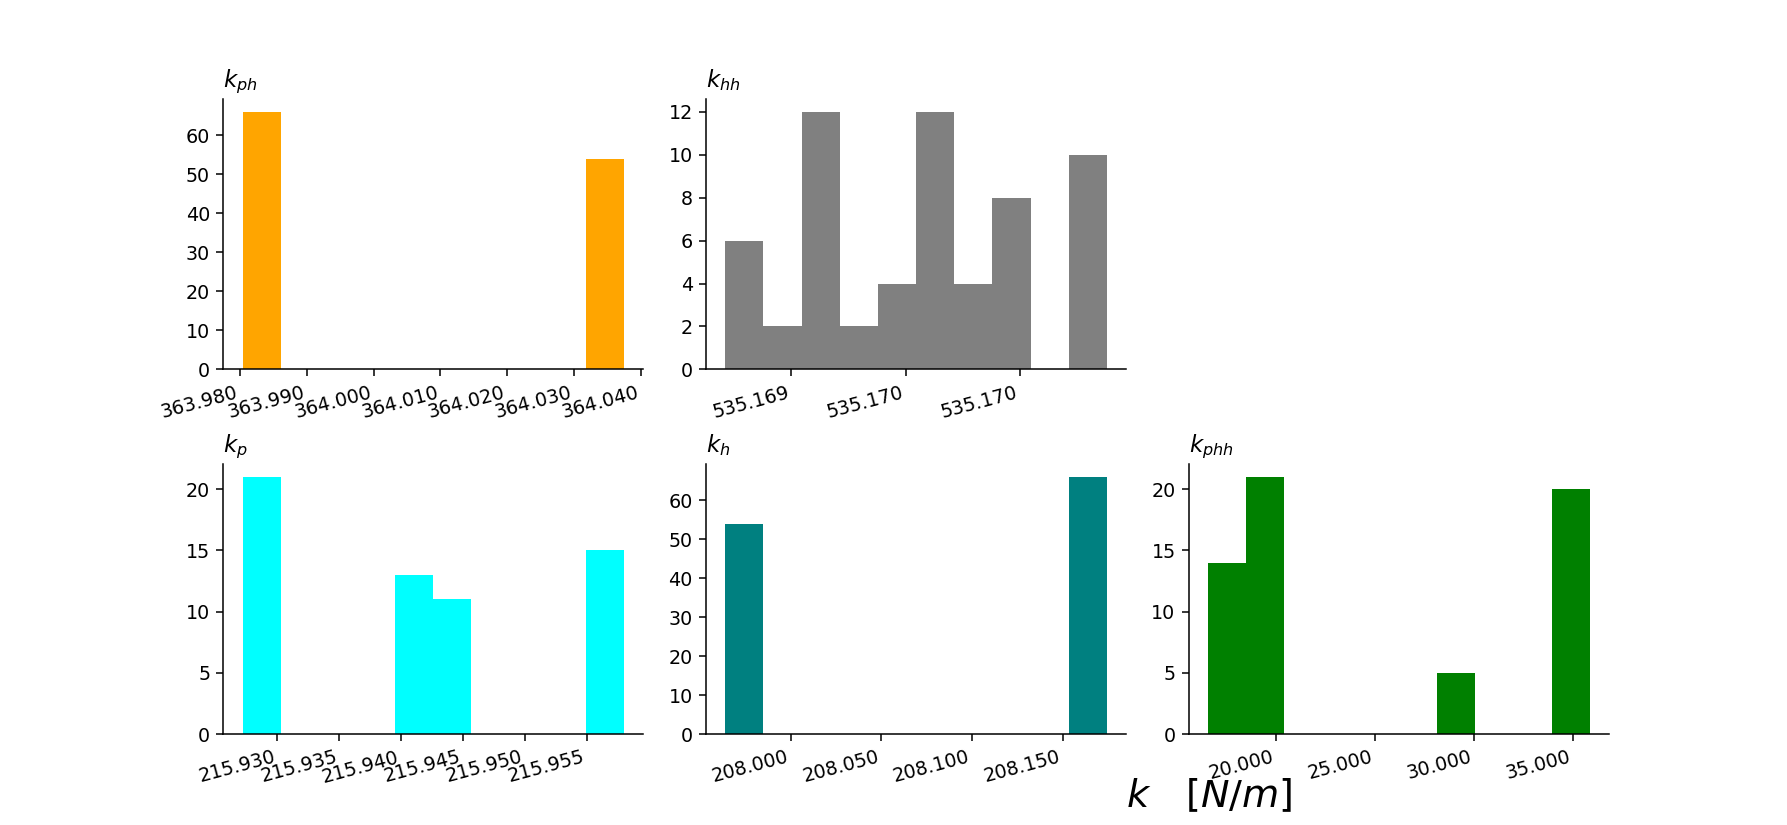

In [92]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.image as image

# im = image.imread('test_geom_image.png')


fig, ax = plt.subplots(2,3,figsize=(13,6))
plt.subplots_adjust(hspace=0.35, wspace=0.15)

# ax[0,0].hist(ph_low_val,bins=1,color='orange')
# ax[0,0].hist(ph_high_val,bins=1,color='teal')
ax[0,0].hist(fc_ph,color='orange')
ax[0,1].hist(fc_hh,color='gray')
ax[1,0].hist(fc_p,color='cyan')
ax[1,1].hist(fc_h,color='teal')
ax[1,2].hist(fc_phh,color='g')
ax[0,2].hist(fc_hhh,color='r')


# ax[0,2].imshow(im, extent=(0.4, 0.6, .5, .7), zorder=-1, aspect='auto')

ax[0,0].xaxis.set_major_formatter(FormatStrFormatter('%.3f') )
ax[0,1].xaxis.set_major_formatter(FormatStrFormatter('%.3f') )
ax[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.3f') )
ax[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.3f') )
ax[1,2].xaxis.set_major_formatter(FormatStrFormatter('%.3f') )


plt.setp(ax[0,0].get_xticklabels(), rotation=15, ha='right')
plt.setp(ax[0,1].get_xticklabels(), rotation=15, ha='right')
plt.setp(ax[1,0].get_xticklabels(), rotation=15, ha='right')
plt.setp(ax[1,1].get_xticklabels(), rotation=15, ha='right')
plt.setp(ax[1,2].get_xticklabels(), rotation=15, ha='right')


ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,1].set_xlabel('$k \quad [N/m]$',fontsize=20,ha='left')
# ax[0,0].set_ylabel('$N$',fontsize=20)
ax[1,1].xaxis.set_label_coords(1,-0.158)
ax[0,0].yaxis.set_label_coords(-0.1,0)


ax[0,0].set_title('$k_{ph}$',loc='left',fontsize=12)
ax[0,1].set_title('$k_{hh}$',loc='left',fontsize=12)
ax[1,0].set_title('$k_{p}$',loc='left',fontsize=12)
ax[1,1].set_title('$k_{h}$',loc='left',fontsize=12)
ax[1,2].set_title('$k_{phh}$',loc='left',fontsize=12)

ax[0,2].set_visible(False)


kph = mpatches.Patch(color='orange', label=f'ph: ')#       {np.array(ph4).mean().round(3)} +/- {np.array(ph4).std().round(3)}')
khh = mpatches.Patch(color='gray', label=f'hh:   ')#     {np.array(hh4).mean().round(3)} +/- {np.array(hh4).std().round(3)}')
kp = mpatches.Patch(color='cyan', label=f'p:     ')#     {np.array(p4).mean().round(3)} +/- {np.array(p4).std().round(3)}')
kh = mpatches.Patch(color='g', label=f'h:        ')#  {np.array(h4).mean().round(3)} +/- {np.array(h4).std().round(3)}')
kphh = mpatches.Patch(color='r', label=f'phh:    ')#  {np.array(phh4).mean().round(3)} +/- {np.array(phh4).std().round(3)}')
# khhh = mpatches.Patch(color='g', label=f'phh:    ')#  {np.array(phh4).mean().round(3)} +/- {np.array(phh4).std().round(3)}')


plt.show()


## Plot force const. on geometry

In [50]:
bond_sort = faces+np.roll(faces,shift=1,axis=-1)
# pp_s_fc        = np.argwhere(bond_sort==10)
ph_s_fc        = np.argwhere(bond_sort==11)
hh_s_fc        = np.argwhere(bond_sort==12)


In [51]:
ang_face_sort = faces.flatten()
p_s_fc        = np.argwhere(ang_face_sort==5)
h_s_fc        = np.argwhere(ang_face_sort==6)


In [53]:
faceSum = np.sum(faces,axis=-1)
# ppp_s_fc = np.argwhere(faceSum==15)
# pph_s_fc = np.argwhere(faceSum==16)
phh_s_fc = np.argwhere(faceSum==17)
# hhh_s_fc = np.argwhere(faceSum==18)

<IPython.core.display.Javascript object>


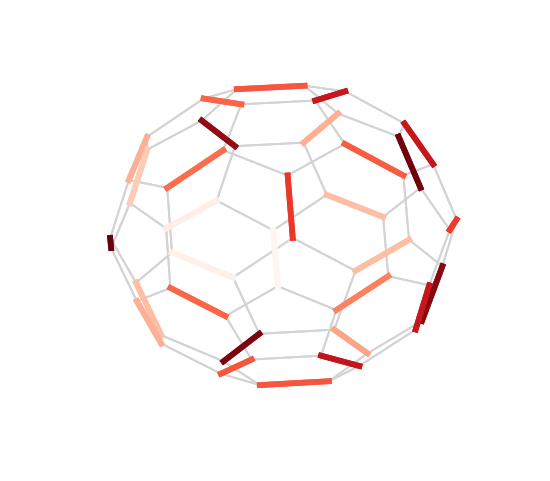

In [71]:
import matplotlib as mpl


fig = plt.figure(figsize=(4,3.5))
ax = Axes3D(fig)


norm_ph = mpl.colors.Normalize(np.min(fc_ph), np.max(fc_ph))

cmap_ph = mpl.cm.ScalarMappable(norm=norm_ph, cmap=mpl.cm.Greens)
cmap_ph.set_array([])

norm_hh = mpl.colors.Normalize(np.min(fc_hh), np.max(fc_hh))

cmap_hh = mpl.cm.ScalarMappable(norm=norm_hh, cmap=mpl.cm.Reds)
cmap_hh.set_array([])





ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_zlim([-3,3])


    
    

for n in range(len(ph_s_fc)):
    at_ph, at_ph_nei_index = ph_s_fc[n]
    
    hs = hessian[neigh[at_ph,at_ph_nei_index],at_ph]
    d = geom[neigh[at_ph,at_ph_nei_index]] - geom[at_ph]
    r = np.linalg.norm(d)
    dhat = d/r
    k_ph = force_const(hs,dhat)
    
    col1 = cmap_ph.to_rgba(k_ph)
    
    coor_at_ph = np.array([geom[at_ph],geom[neigh[at_ph,at_ph_nei_index]]])
#     ax.plot(coor_at_ph[:,0], coor_at_ph[:,1], coor_at_ph[:,2], color=col1 ,linewidth=3)
    ax.plot(coor_at_ph[:,0], coor_at_ph[:,1], coor_at_ph[:,2], color='lightgray' ,linewidth=1)

for m in range(len(hh_s_fc)):
    at_hh, at_hh_nei_index = hh_s_fc[m]
    
    hs = hessian[neigh[at_hh,at_hh_nei_index],at_hh]
    d = geom[neigh[at_hh,at_hh_nei_index]] - geom[at_hh]
    r = np.linalg.norm(d)
    dhat = d/r
    k_hh = force_const(hs,dhat)
    
    col2 = cmap_hh.to_rgba(k_hh)
    
    coor_at_hh = np.array([geom[at_hh],geom[neigh[at_hh,at_hh_nei_index]]])
    ax.plot(coor_at_hh[:,0], coor_at_hh[:,1], coor_at_hh[:,2], color=col2,linewidth=3)
#     ax.plot(coor_at_hh[:,0], coor_at_hh[:,1], coor_at_hh[:,2], color='lightgray' ,linewidth=1)

    
ax.axis('off');


<IPython.core.display.Javascript object>


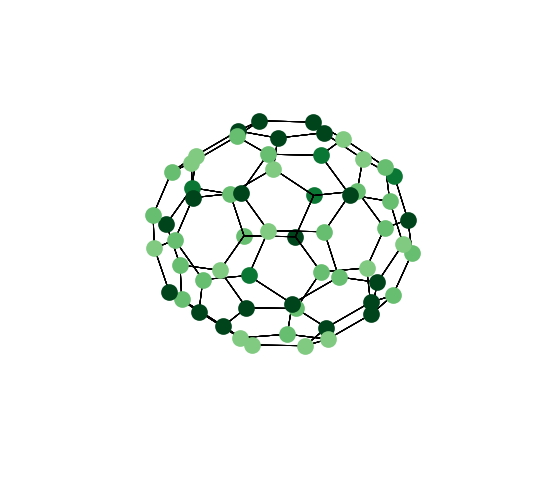

(60, 3, 3)
60


In [91]:



#DIHEDRAL TEST

norm1 = mpl.colors.Normalize(0, np.max(fc_dih[phh_s_fc]))
cmap1 = mpl.cm.ScalarMappable(norm=norm1, cmap=mpl.cm.Greens)
cmap1.set_array([])

fig = plt.figure(figsize=(4,3.5))
ax = Axes3D(fig)

ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
ax.set_zlim([-4,4])

neighX    = geom[neigh]
nextplus  = geom[next_on_face]
prevminus = geom[prev_on_face]

print(nextplus.shape)
a = geom
b,c,d = neighX[:,0,:], neighX[:,1,:], neighX[:,2,:]

bp,cp,dp = nextplus[:,0,:], nextplus[:,1,:], nextplus[:,2,:]
bm,cm,dm = prevminus[:,0,:], prevminus[:,1,:], prevminus[:,2,:]

bb = np.array([a,b,bm,b,bp])
cc = np.array([a,c,cm,c,cp])
dd = np.array([a,d,dm,d,dp])

n = bb.shape[1]

print(n)
for i in range(n):
    ax.plot(bb[:,i,0], bb[:,i,1], bb[:,i,2], color='k',linewidth=0.5)
    ax.plot(cc[:,i,0], cc[:,i,1], cc[:,i,2], color='k',linewidth=0.5)
    ax.plot(dd[:,i,0], dd[:,i,1], dd[:,i,2], color='k',linewidth=0.5)


for i in phh_s_fc:
    
    col1 = cmap1.to_rgba(fc_dih[i])
    ax.scatter(geom[i,0],geom[i,1],geom[i,2], color = col1, s = 60)
    
ax.axis('off');